<a href="https://colab.research.google.com/github/rizkiatthoriq/geographic-data-science/blob/main/Mangrove_AGB_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Refer to : https://www.kaggle.com/code/ludovicocuoghi/xgboost-optuna-deep-feature-engineering-r2-93 (r2 - 93%)

In [ ]:
import os
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

loc = '/content/drive/MyDrive/Portfolio/Mangrove AGB Modeling/'
# create a path if it doesn't exist
if not os.path.exists(loc):
    os.makedirs(loc)
os.chdir(loc)
print('Working Directory: ',os.getcwd())

Mounted at /content/drive
Working Directory:  /content/drive/MyDrive/Portfolio/Mangrove AGB Modeling


In [ ]:
import ee
import geemap

# Initialize the Earth Engine library.
ee.Authenticate()
ee.Initialize(project='ee-rizkiatthoriq99-9')

In [ ]:
m = geemap.Map()
m

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [ ]:
# prompt: Define the boundary based on precission administration boundary in KEpualauan Mentawaiu (ADM 2

# Import the Indonesia boundary
indonesia = ee.FeatureCollection("FAO/GAUL/2015/level2").filter(ee.Filter.eq('ADM0_NAME', 'Indonesia'));

# Filter the boundary to get Kepulauan Mentawai
kep_mentawai = indonesia.filter(ee.Filter.eq('ADM2_NAME', 'Kepulauan Mentawai'))

# Display the boundary on the map
m.addLayer(kep_mentawai, {}, 'Kepulauan Mentawai')
m.centerObject(kep_mentawai, 10)
m

Map(bottom=812.0, center=[-1.8653147687211522, 99.33598215219381], controls=(WidgetControl(options=['position'…

In [ ]:
# # Define the coordinates of the box
# coords = [
#     [116.973725, -0.999705],
#     [116.973725, -0.258178],
#     [117.780991, -0.258178],
#     [117.780991, -0.999705],
#     [116.973725, -0.999705]  # Close the polygon
# ]

# # Create a geometry object from the coordinates
# box = ee.Geometry.Polygon(coords, None, False)

# # Add the box to the map (optional)
# m.addLayer(box, {}, 'Box')

# # Center the map on the box
# m.centerObject(box, 10)  # Adjust the zoom level as needed

# m


Map(bottom=812.0, center=[-0.6289379235133751, 117.37735799999996], controls=(WidgetControl(options=['position…

In [ ]:
# prompt: startDate = '2022-01-01', '2022-12-31'end

startDate = '2022-01-01'
endDate = '2022-12-31'


In [ ]:
box = kep_mentawai.geometry()

# Import the Landsat 8 image collection.
l8 = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
    .filterBounds(box) \
    .filterDate(startDate, endDate) \

#Landsat 8 cloud masking
def maskL8sr(image):
    # Bits 3 and 5 are cloud shadow and cloud, respectively.
    cloudShadowBitMask = 1 << 3
    cloudsBitMask = 1 << 5

    # Get the pixel QA band.
    qa = image.select('QA_PIXEL') # Use 'QA_PIXEL' instead of 'pixel_qa'

    # Both flags  be set to zero, indicating clear conditions.
    mask1 = qa.bitwiseAnd(cloudShadowBitMask).eq(0) \
    .And(qa.bitwiseAnd(cloudsBitMask).eq(0))

    mask2 = image.select('SR_B.*').gt(0).reduce('min')

# Return the masked image, scaled to TOA reflectance, without the QA bands.
    return image.updateMask(mask1.And(mask2)).divide(10000) \
    .select("SR_B[0-9]*") \
    .copyProperties(image, ["system:time_start"])

# Apply cloud masking to the Landsat 8 collection.
l8_noclouds = l8.map(maskL8sr).median().clip(box)

# Visualize map
m.addLayer(l8_noclouds, {'bands': ['SR_B4', 'SR_B3', 'SR_B2'], 'min':0.6, 'max': 1.4}, 'Landsat 8')
m

Map(bottom=132731.0, center=[-1.8653147687211522, 99.33598215219381], controls=(WidgetControl(options=['positi…

In [ ]:
# prompt: calculate spectral indices (at least 6: ndvi, ndbi, savi, bsi, ndwi) , add all to bands and visualize

# Calculate spectral indices
ndvi = l8_noclouds.normalizedDifference(['SR_B5', 'SR_B4']).rename('NDVI')
ndbi = l8_noclouds.normalizedDifference(['SR_B6', 'SR_B5']).rename('NDBI')
savi = l8_noclouds.expression('(1 + 0.5)*(nir - red) / (nir + red + 0.5)', {
    'nir': l8_noclouds.select('SR_B5'),
    'red': l8_noclouds.select('SR_B4')
}).rename('SAVI')
bsi = l8_noclouds.expression('((swir1 + red) - (nir + blue)) / ((swir1 + red) + (nir + blue))', {
    'swir1': l8_noclouds.select('SR_B6'),
    'red': l8_noclouds.select('SR_B4'),
    'nir': l8_noclouds.select('SR_B5'),
    'blue': l8_noclouds.select('SR_B2')
}).rename('BSI')
ndwi = l8_noclouds.normalizedDifference(['SR_B3', 'SR_B5']).rename('NDWI')
evi = l8_noclouds.expression('2.5 * (nir - red) / (nir + 6 * red - 7.5 * blue + 1)', {
    'nir': l8_noclouds.select('SR_B5'),
    'red': l8_noclouds.select('SR_B4'),
    'blue': l8_noclouds.select('SR_B2')
}).rename('EVI')

# Add indices to the image
l8_with_indices = l8_noclouds.addBands(ndvi).addBands(ndbi).addBands(savi).addBands(bsi).addBands(ndwi).addBands(evi)

# Visualize NDVI
m.addLayer(ndvi, {'min': -1, 'max': .5, 'palette': ['blue', 'white', 'green']}, 'NDVI')
m


Map(bottom=132731.0, center=[-1.8653147687211522, 99.33598215219381], controls=(WidgetControl(options=['positi…

In [ ]:
# Import the ALOS AW3D30 digital elevation model.
elevation = ee.Image("CGIAR/SRTM90_V4").select('elevation').clip(box)

# Calculate slope from the elevation data.
slope = ee.Terrain.slope(elevation)

# Add elevation and slope to the image
l8_with_indices = l8_with_indices.addBands(elevation.rename('ELEVATION')).addBands(slope.rename('SLOPE'))

# Visualize elevation
m.addLayer(elevation, {'min': 0, 'max': 100, 'palette': ['#333399', '#00cc66', '#ffff99', '#805c54', '#ffffff']}, 'Elevation')
m


Map(bottom=132731.0, center=[-1.8653147687211522, 99.33598215219381], controls=(WidgetControl(options=['positi…

In [ ]:
# Function to select highest quality GEDI data
def func_zzt(image):
    # Use 'l2b_quality_flag' instead of 'l4_quality_flag'
    return image.updateMask(image.select('l2_quality_flag').eq(1)) \
    .updateMask(image.select('degrade_flag').eq(0))

qualityMask = func_zzt


# Function to mask unreliable GEDI measurements
# with a relative standard error > 50%
# agbd_se / agbd > 0.5
def func_wol(image):
    relative_se = image.select('agbd_se') \
    .divide(image.select('agbd'))
    return image.updateMask(relative_se.lte(0.5))

errorMask = func_wol

# Function to mask slope
def fun_slp(image):
    return image.updateMask(l8_with_indices.select('SLOPE').lt(30))

slopeMask = fun_slp


In [ ]:
gedi = ee.ImageCollection("LARSE/GEDI/GEDI04_A_002_MONTHLY") \
          .filterDate('2022-01-01', '2022-12-31') \
          .map(qualityMask) \
          .map(errorMask) \
          .map(slopeMask) \
          .select('agbd') \
          .median() \
          .clip(box)

m.addLayer(gedi, {'min': 0, 'max': 100}, 'GEDI AGB')
m

Map(bottom=132731.0, center=[-1.8653147687211522, 99.33598215219381], controls=(WidgetControl(options=['positi…

In [ ]:
# Convert GEDI image to points
gedi_points = gedi.sample(**{
    'region':box,
    'geometries':True,
    'scale':25,  # Adjust the scale as needed
})

# Add GEDI points to the map
m.addLayer(gedi_points, {'color': 'yellow'}, 'GEDI Points')
m


Map(bottom=132731.0, center=[-1.8653147687211522, 99.33598215219381], controls=(WidgetControl(options=['positi…

In [ ]:
# # prompt: Select 1000 Random points

# # Select 1000 random points
# random_gedi_points = gedi_points.randomColumn('random',seed=42).sort('random').limit(1000)

# # Add random points to the map
# m.addLayer(random_gedi_points, {'color': 'red'}, 'Random GEDI Points')
# m

random_gedi_points = gedi_points

In [ ]:
# prompt: sample the l8_with_indices with fgedi points to get the pixel values of bands

# Sample the Landsat image at the GEDI point locations
sampled_data = l8_with_indices.sampleRegions(
    collection=random_gedi_points,
    geometries=True,
    scale=25
)


In [ ]:
sampled_data_df = geemap.ee_to_df(sampled_data)#.drop('random', axis=1)
sampled_data_df.head()

BSI  ELEVATION       EVI      NDBI      NDVI      NDWI      SAVI  \
0 -0.130992          7  1.395650 -0.209586  0.385602 -0.342779  0.486809   
1 -0.135277          7  1.374591 -0.218251  0.376946 -0.330638  0.474741   
2 -0.160334         10  1.425345 -0.255371  0.399115 -0.365225  0.506151   
3 -0.110378         13  1.083207 -0.197472  0.318126 -0.287042  0.395539   
4 -0.115570         13  1.217884 -0.196865  0.335660 -0.301079  0.419366   

      SLOPE    SR_B1    SR_B2   SR_B3    SR_B4    SR_B5    SR_B6    SR_B7  \
0  0.437584  0.76300  0.78715  0.9011  0.81635  1.84105  1.20305  0.92820   
1  0.437584  0.77340  0.78675  0.9066  0.81550  1.80225  1.15650  0.93235   
2  1.274631  0.75540  0.79060  0.8897  0.82180  1.91350  1.13500  0.91120   
3  1.115143  0.75105  0.76970  0.8843  0.82580  1.59635  1.06985  0.92005   
4  1.115143  0.77050  0.78865  0.8942  0.82795  1.66460  1.11700  0.89725   

        agbd  
0  63.734005  
1  40.492432  
2  88.166046  
3  51.365906  
4  65.674110

In [ ]:
sampled_data_df

BSI  ELEVATION       EVI      NDBI      NDVI      NDWI      SAVI  \
0     -0.130992          7  1.395650 -0.209586  0.385602 -0.342779  0.486809   
1     -0.135277          7  1.374591 -0.218251  0.376946 -0.330638  0.474741   
2     -0.160334         10  1.425345 -0.255371  0.399115 -0.365225  0.506151   
3     -0.110378         13  1.083207 -0.197472  0.318126 -0.287042  0.395539   
4     -0.115570         13  1.217884 -0.196865  0.335660 -0.301079  0.419366   
...         ...        ...       ...       ...       ...       ...       ...   
54474 -0.123750         44  1.433679 -0.201455  0.358369 -0.316674  0.456596   
54475 -0.145740         25  1.347390 -0.237664  0.330965 -0.297563  0.407168   
54476 -0.195844         85  1.622559 -0.293982  0.464843 -0.430307  0.599406   
54477 -0.175059         61  1.595715 -0.266019  0.436189 -0.399936  0.557461   
54478 -0.185202         21  1.554451 -0.283961  0.437167 -0.396896  0.558420   

           SLOPE    SR_B1    SR_B2    SR_B3    SR_B4    SR_B5    SR_B6  \
0       0.437584  0.76300  0.78715  0.90110  0.81635  1.84105  1.20305   
1       0.437584  0.77340  0.78675  0.90660  0.81550  1.80225  1.15650   
2       1.274631  0.75540  0.79060  0.88970  0.82180  1.91350  1.13500   
3       1.115143  0.75105  0.76970  0.88430  0.82580  1.59635  1.06985   
4       1.115143  0.77050  0.78865  0.89420  0.82795  1.66460  1.11700   
...          ...      ...      ...      ...      ...      ...      ...   
54474   3.452857  0.85590  0.87750  0.99400  0.90470  1.91530  1.27300   
54475   0.691358  0.74760  0.75920  0.82150  0.76280  1.51750  0.93470   
54476  10.827498  0.77775  0.79555  0.89345  0.81950  2.24315  1.22390   
54477  15.100624  0.76910  0.79590  0.88610  0.81155  2.06725  1.19850   
54478   1.545522  0.75930  0.78510  0.89000  0.80730  2.06140  1.14960   

         SR_B7        agbd  
0      0.92820   63.734005  
1      0.93235   40.492432  
2      0.91120   88.166046  
3      0.92005   51.365906  
4      0.89725   65.674110  
...        ...         ...  
54474  1.08940   68.274475  
54475  0.79850  107.526085  
54476  0.94155  137.793610  
54477  0.90905  157.048218  
54478  0.88310   44.036983  

[54479 rows x 16 columns]

In [ ]:
# prompt: Do intial Exploratory Data Analysis for sampled data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Descriptive statistics
sampled_data_df.describe()



BSI     ELEVATION           EVI          NDBI          NDVI  \
count  54479.000000  54479.000000  54479.000000  54479.000000  54479.000000   
mean      -0.146058     88.720241      1.396052     -0.234577      0.388372   
std        0.024870     62.310023      0.251654      0.030484      0.047971   
min       -0.290144      0.000000    -22.012690     -0.380396     -0.021227   
25%       -0.162778     38.000000      1.318493     -0.254803      0.365195   
50%       -0.148511     73.000000      1.429797     -0.236777      0.396748   
75%       -0.131947    124.000000      1.504243     -0.216800      0.420574   
max        0.055285    336.000000     25.052807     -0.044040      0.525579   

               NDWI          SAVI         SLOPE         SR_B1         SR_B2  \
count  54479.000000  54479.000000  54479.000000  54479.000000  54479.000000   
mean      -0.354561      0.493134      7.026094      0.784576      0.802963   
std        0.044058      0.065114      5.073999      0.062946      0.063946   
min       -0.496119     -0.027730      0.000000      0.160400      0.293200   
25%       -0.384090      0.460405      2.934075      0.767400      0.784600   
50%       -0.361882      0.503620      5.887146      0.776650      0.794550   
75%       -0.332987      0.537037      9.994355      0.790000      0.807900   
max       -0.035326      0.690037     29.797874      2.687700      2.803600   

              SR_B3         SR_B4         SR_B5         SR_B6         SR_B7  \
count  54479.000000  54479.000000  54479.000000  54479.000000  54479.000000   
mean       0.907792      0.838991      1.915535      1.183858      0.928828   
std        0.070313      0.070633      0.205301      0.098327      0.061078   
min        0.577300      0.558500      0.936400      0.783100      0.752500   
25%        0.877650      0.811900      1.799600      1.128200      0.894700   
50%        0.897300      0.825500      1.930900      1.180500      0.919400   
75%        0.922500      0.845600      2.048250      1.234300      0.950000   
max        2.737600      2.800000      3.408300      2.471800      1.991200   

               agbd  
count  54479.000000  
mean     244.892532  
std      152.890300  
min       34.266281  
25%      129.535614  
50%      217.464279  
75%      325.520706  
max     2054.424072

In [ ]:
# Check for missing values
sampled_data_df.isnull().sum()

BSI          0
ELEVATION    0
EVI          0
NDBI         0
NDVI         0
NDWI         0
SAVI         0
SLOPE        0
SR_B1        0
SR_B2        0
SR_B3        0
SR_B4        0
SR_B5        0
SR_B6        0
SR_B7        0
agbd         0
dtype: int64

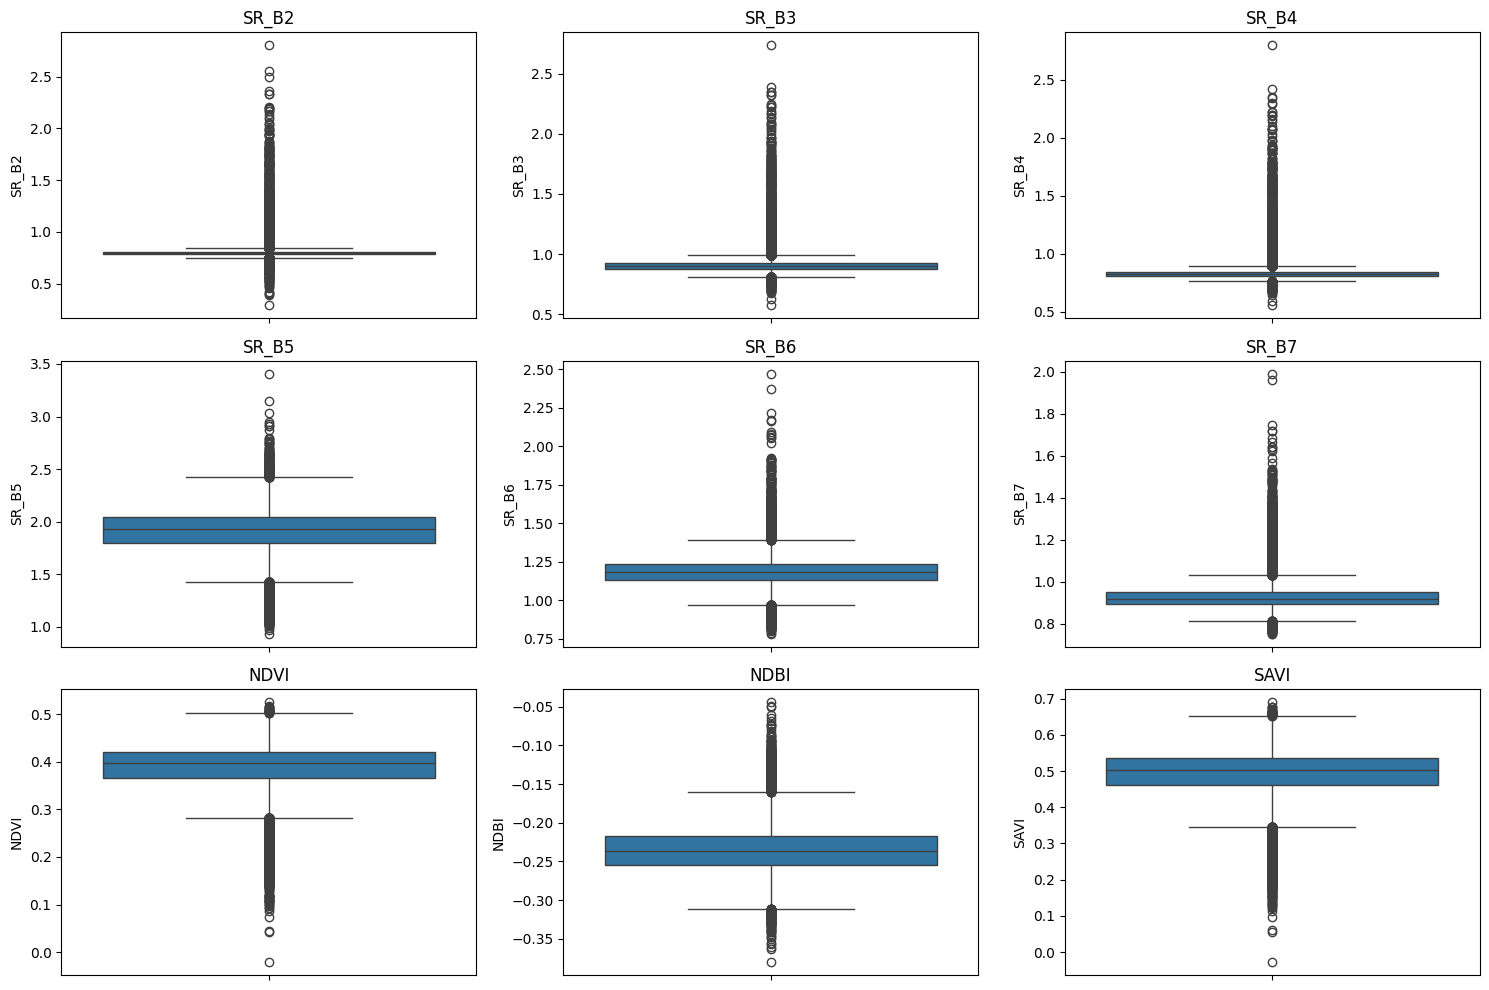

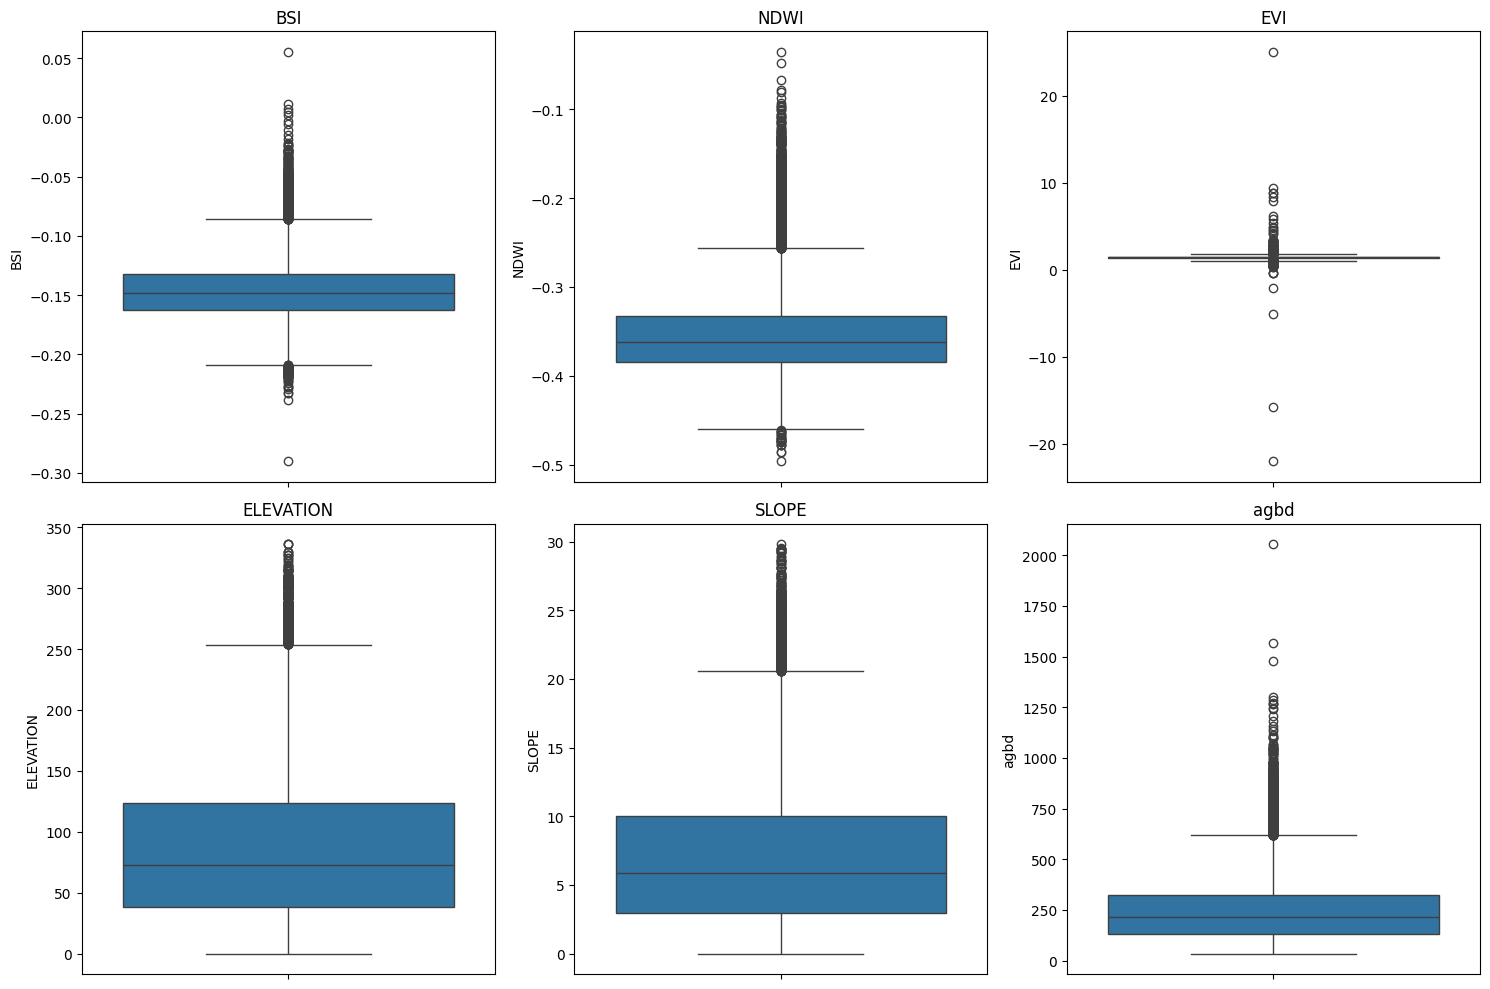

In [ ]:
# prompt: check the distribution of data throuigh boxplot. each data in each subplot

# Create subplots for each variable
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))

# Plot boxplots for each variable
sns.boxplot(y=sampled_data_df['SR_B2'], ax=axes[0, 0])
sns.boxplot(y=sampled_data_df['SR_B3'], ax=axes[0, 1])
sns.boxplot(y=sampled_data_df['SR_B4'], ax=axes[0, 2])
sns.boxplot(y=sampled_data_df['SR_B5'], ax=axes[1, 0])
sns.boxplot(y=sampled_data_df['SR_B6'], ax=axes[1, 1])
sns.boxplot(y=sampled_data_df['SR_B7'], ax=axes[1, 2])
sns.boxplot(y=sampled_data_df['NDVI'], ax=axes[2, 0])
sns.boxplot(y=sampled_data_df['NDBI'], ax=axes[2, 1])
sns.boxplot(y=sampled_data_df['SAVI'], ax=axes[2, 2])

# Set titles for each subplot
axes[0, 0].set_title('SR_B2')
axes[0, 1].set_title('SR_B3')
axes[0, 2].set_title('SR_B4')
axes[1, 0].set_title('SR_B5')
axes[1, 1].set_title('SR_B6')
axes[1, 2].set_title('SR_B7')
axes[2, 0].set_title('NDVI')
axes[2, 1].set_title('NDBI')
axes[2, 2].set_title('SAVI')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

# Create subplots for the remaining variables
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

# Plot boxplots for the remaining variables
sns.boxplot(y=sampled_data_df['BSI'], ax=axes[0, 0])
sns.boxplot(y=sampled_data_df['NDWI'], ax=axes[0, 1])
sns.boxplot(y=sampled_data_df['EVI'], ax=axes[0, 2])
sns.boxplot(y=sampled_data_df['ELEVATION'], ax=axes[1, 0])
sns.boxplot(y=sampled_data_df['SLOPE'], ax=axes[1, 1])
sns.boxplot(y=sampled_data_df['agbd'], ax=axes[1, 2])

# Set titles for each subplot
axes[0, 0].set_title('BSI')
axes[0, 1].set_title('NDWI')
axes[0, 2].set_title('EVI')
axes[1, 0].set_title('ELEVATION')
axes[1, 1].set_title('SLOPE')
axes[1, 2].set_title('agbd')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


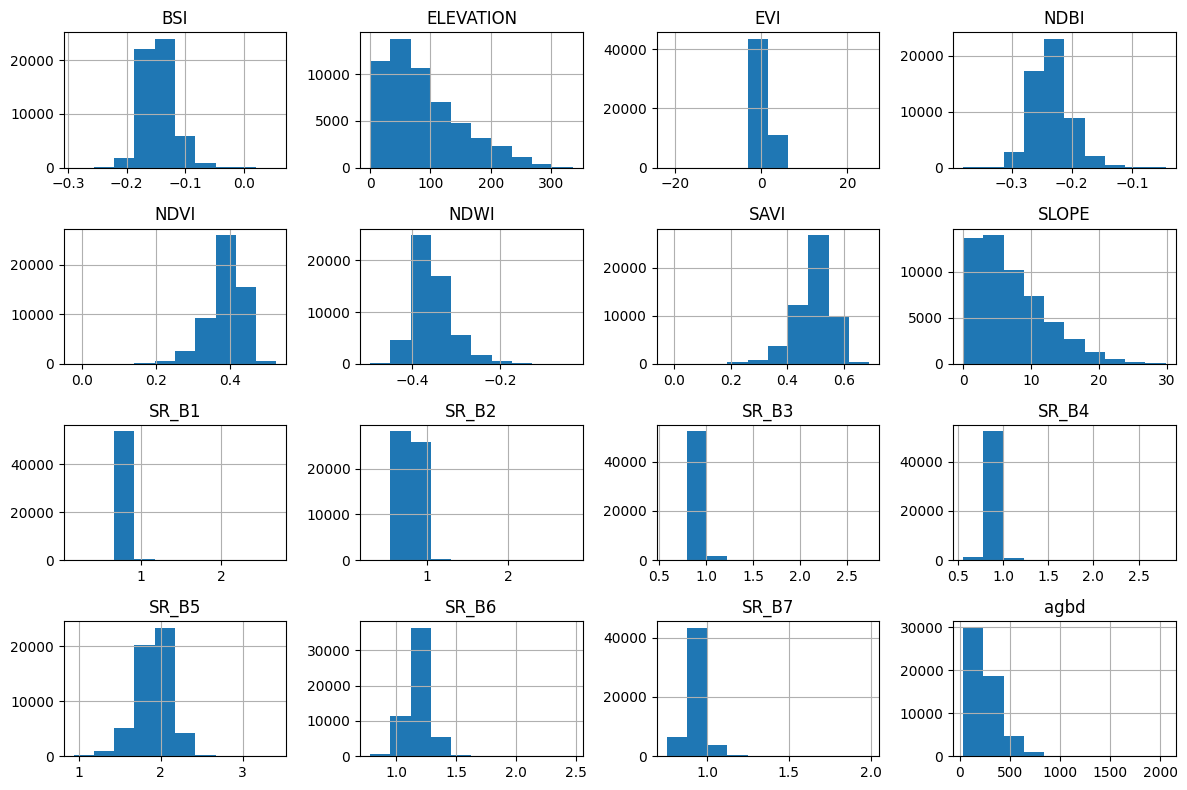

In [ ]:
# Histograms for numerical features
sampled_data_df.hist(figsize=(12, 8))
plt.tight_layout()
plt.show()

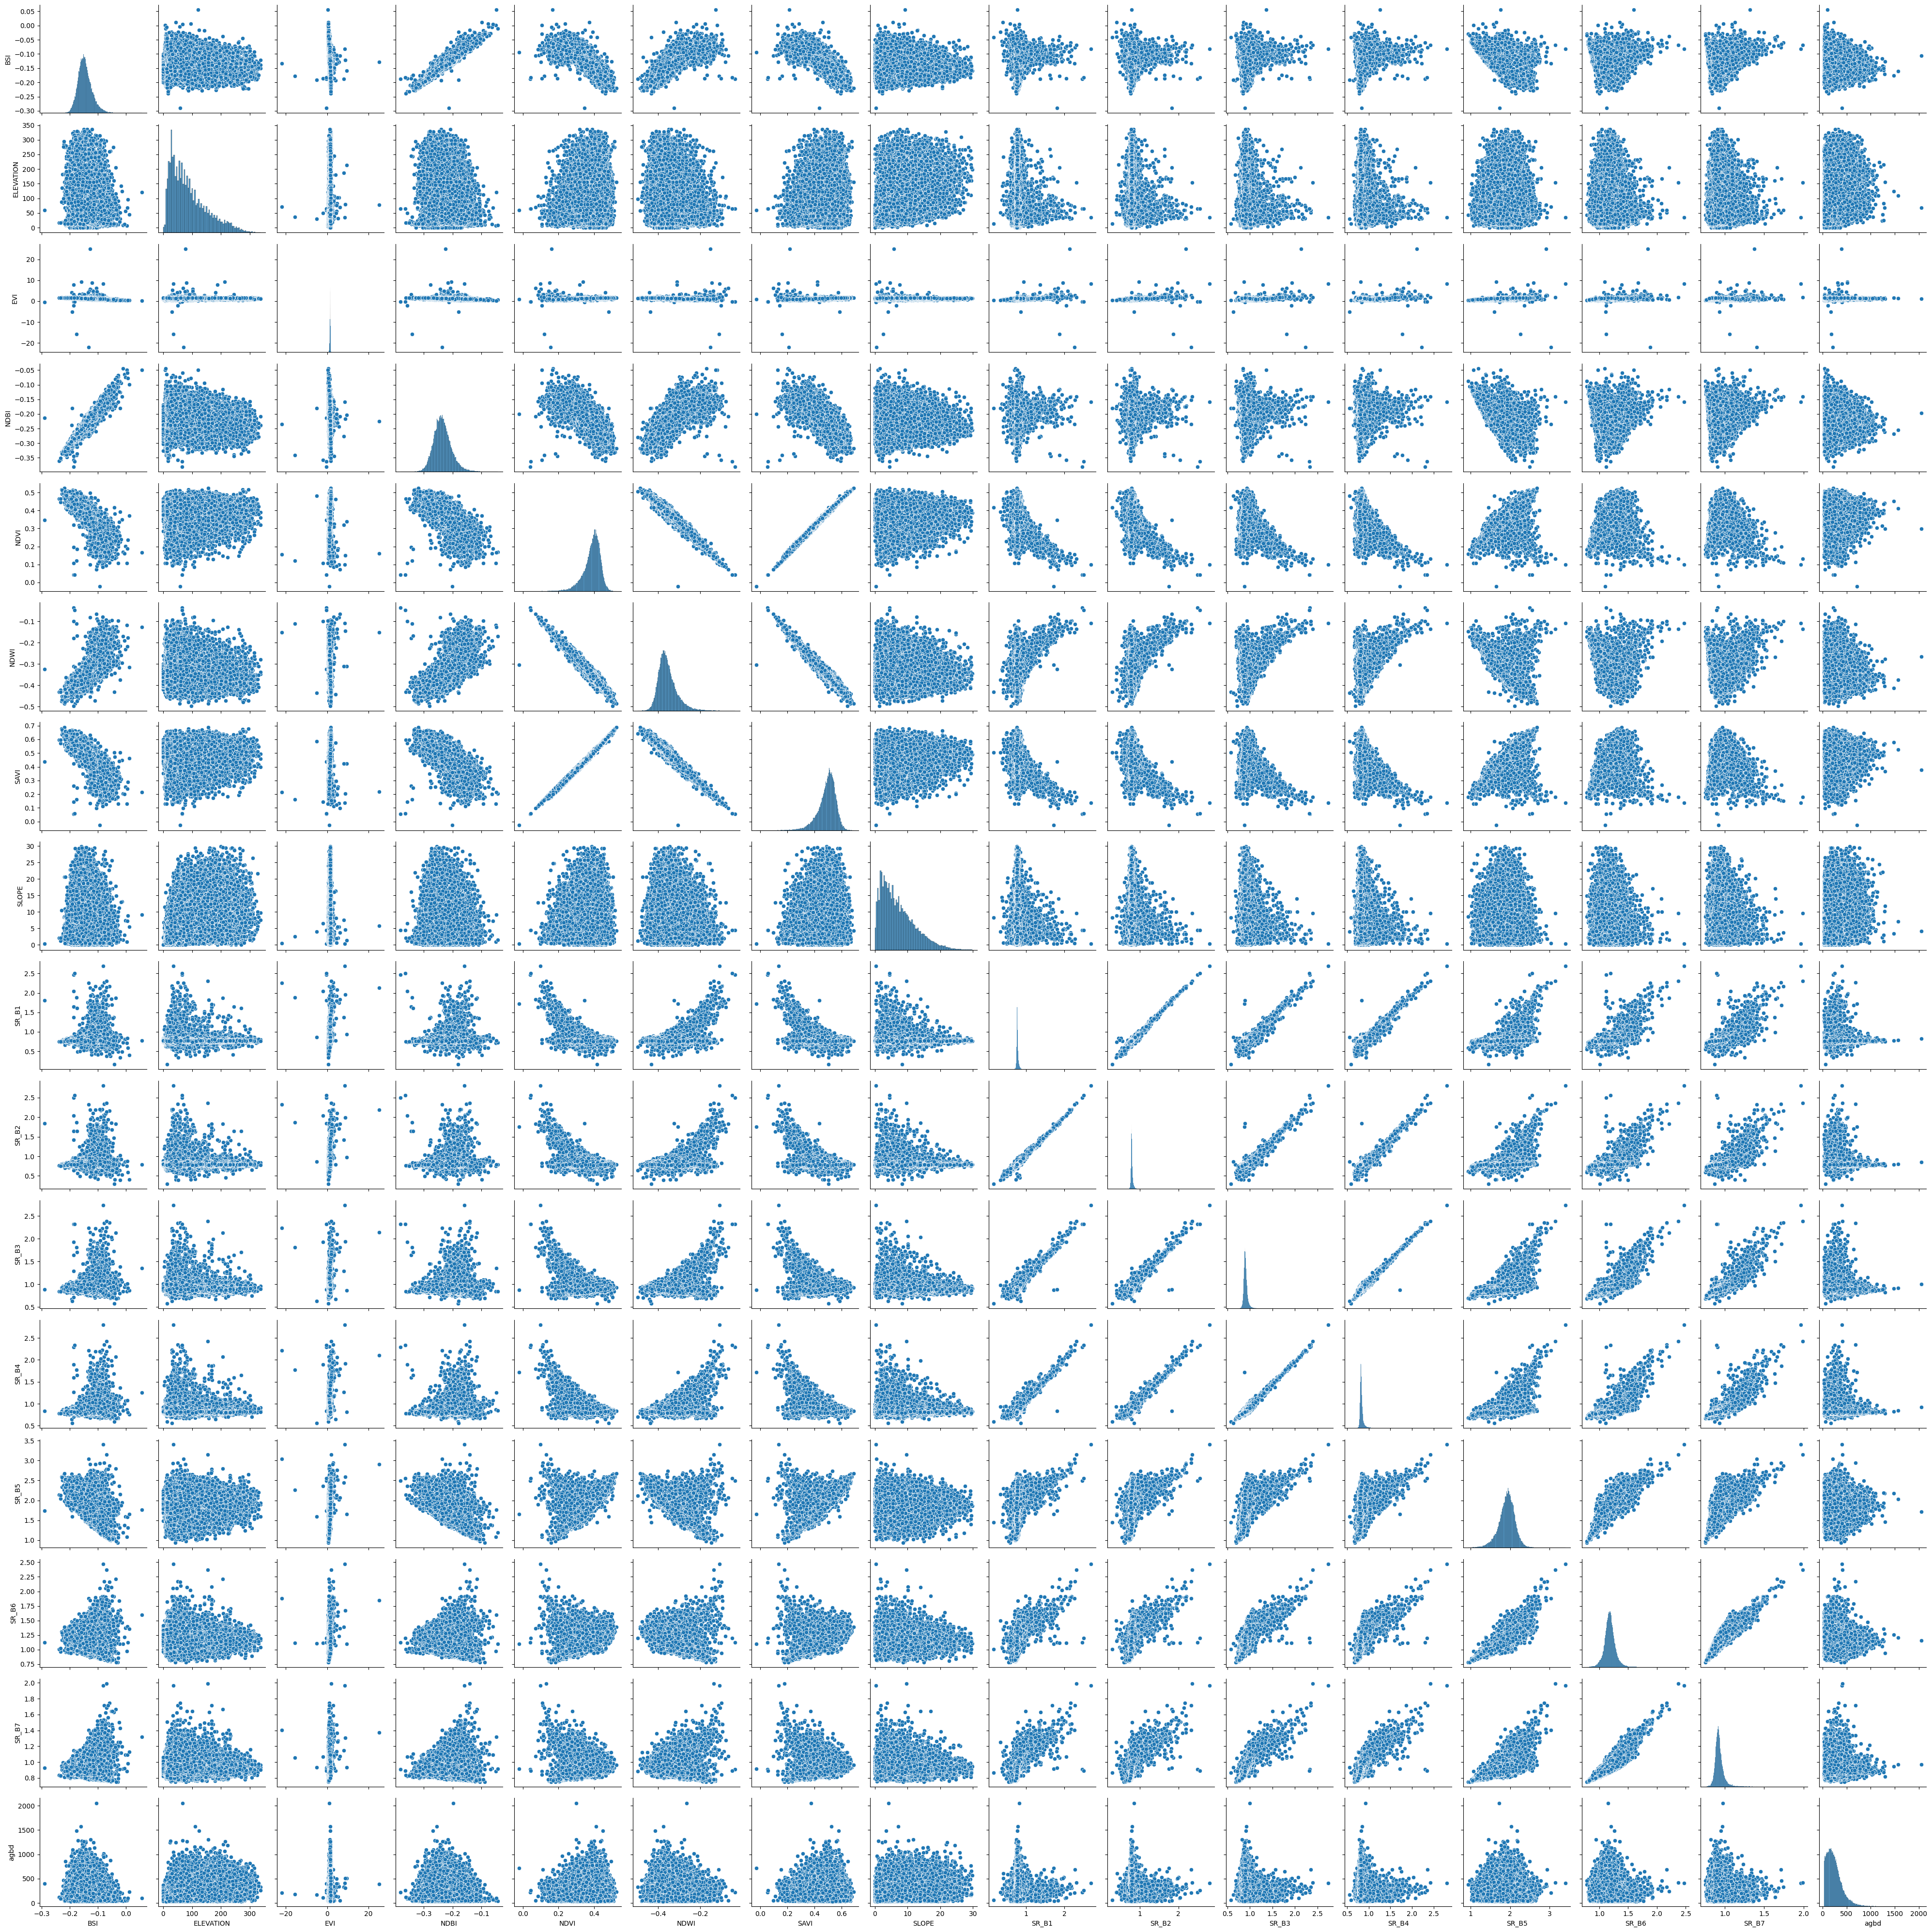

In [ ]:
# Scatter plots for relationships between features
sns.pairplot(sampled_data_df)
plt.tight_layout()
plt.show()

In [ ]:
# prompt: clean the outlier

# Calculate the IQR for each variable
Q1 = sampled_data_df.quantile(0.25)
Q3 = sampled_data_df.quantile(0.75)
IQR = Q3 - Q1

# Define the outlier boundaries
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter the DataFrame to remove outliers
filtered_data_df = sampled_data_df[~((sampled_data_df < lower_bound) | (sampled_data_df > upper_bound)).any(axis=1)]

# Display the shape of the original and filtered DataFrames
print("Original DataFrame shape:", sampled_data_df.shape)
print("Filtered DataFrame shape:", filtered_data_df.shape)

# filtered_data_df = sampled_data_df

Original DataFrame shape: (54479, 16)
Filtered DataFrame shape: (42672, 16)


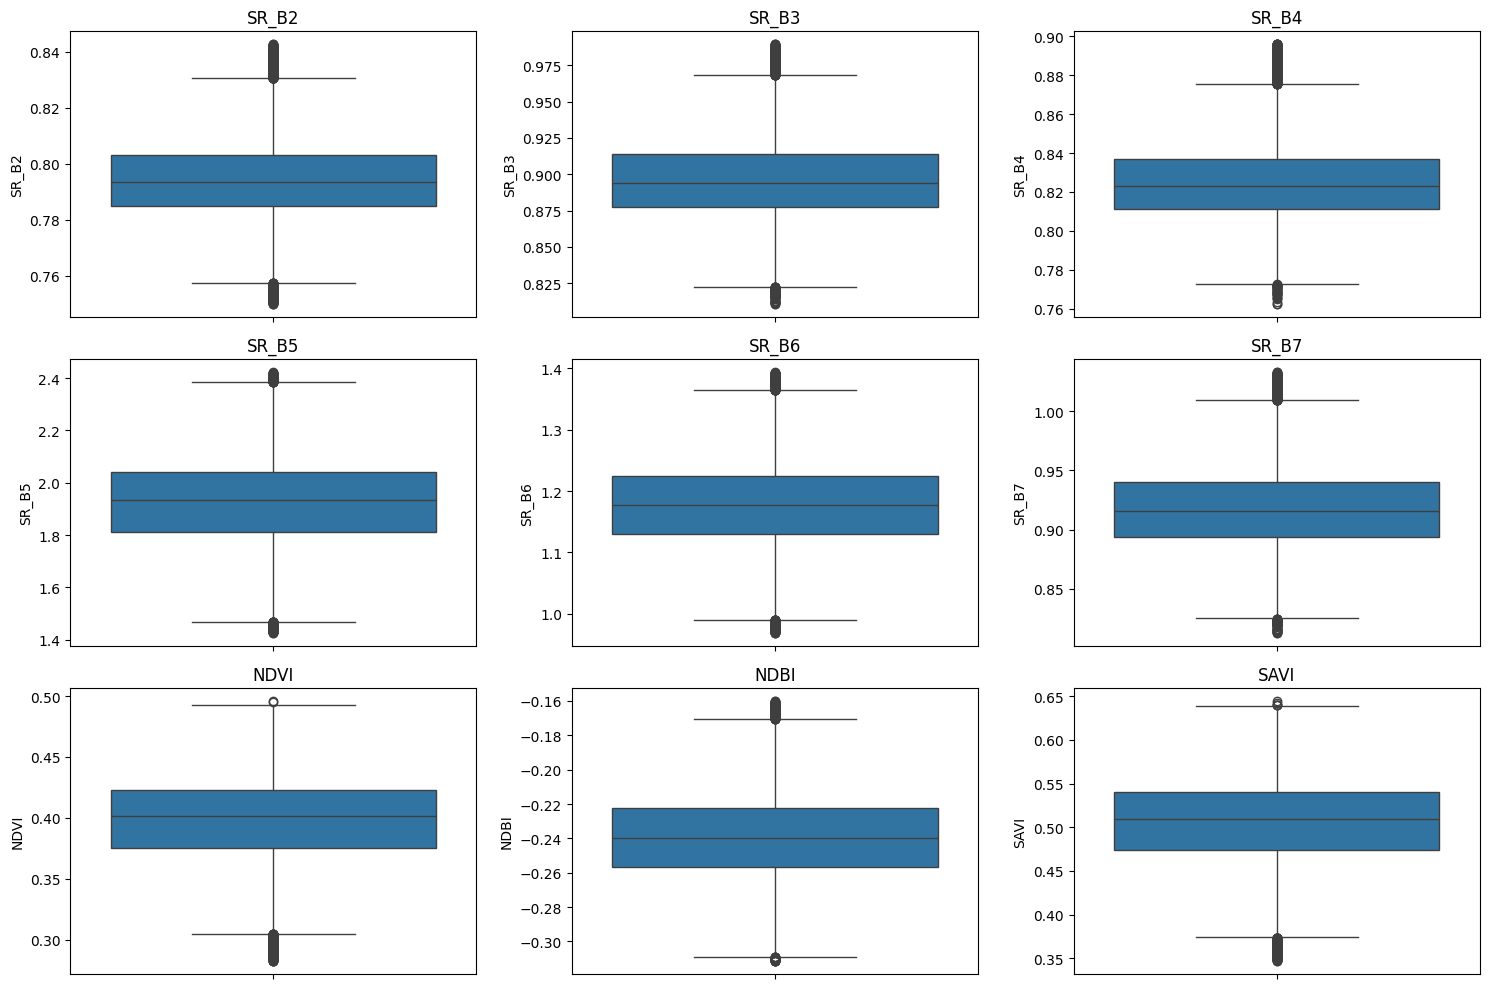

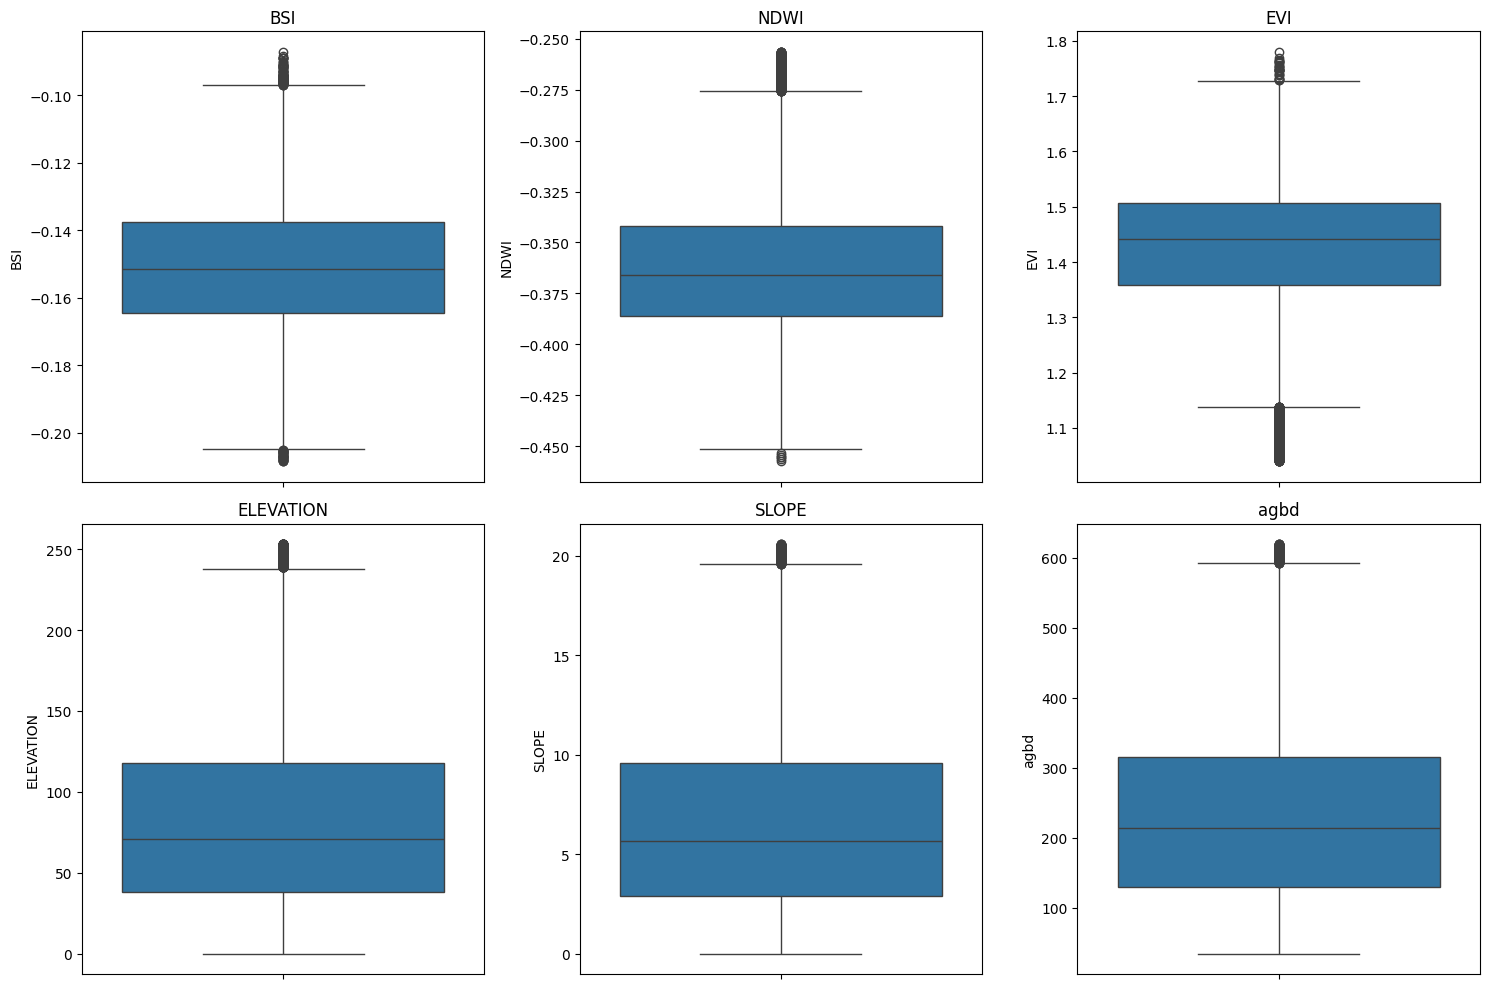

In [ ]:
# prompt: show the boxplot for filtered data

# Create subplots for each variable
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))

# Plot boxplots for each variable
sns.boxplot(y=filtered_data_df['SR_B2'], ax=axes[0, 0])
sns.boxplot(y=filtered_data_df['SR_B3'], ax=axes[0, 1])
sns.boxplot(y=filtered_data_df['SR_B4'], ax=axes[0, 2])
sns.boxplot(y=filtered_data_df['SR_B5'], ax=axes[1, 0])
sns.boxplot(y=filtered_data_df['SR_B6'], ax=axes[1, 1])
sns.boxplot(y=filtered_data_df['SR_B7'], ax=axes[1, 2])
sns.boxplot(y=filtered_data_df['NDVI'], ax=axes[2, 0])
sns.boxplot(y=filtered_data_df['NDBI'], ax=axes[2, 1])
sns.boxplot(y=filtered_data_df['SAVI'], ax=axes[2, 2])

# Set titles for each subplot
axes[0, 0].set_title('SR_B2')
axes[0, 1].set_title('SR_B3')
axes[0, 2].set_title('SR_B4')
axes[1, 0].set_title('SR_B5')
axes[1, 1].set_title('SR_B6')
axes[1, 2].set_title('SR_B7')
axes[2, 0].set_title('NDVI')
axes[2, 1].set_title('NDBI')
axes[2, 2].set_title('SAVI')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

# Create subplots for the remaining variables
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

# Plot boxplots for the remaining variables
sns.boxplot(y=filtered_data_df['BSI'], ax=axes[0, 0])
sns.boxplot(y=filtered_data_df['NDWI'], ax=axes[0, 1])
sns.boxplot(y=filtered_data_df['EVI'], ax=axes[0, 2])
sns.boxplot(y=filtered_data_df['ELEVATION'], ax=axes[1, 0])
sns.boxplot(y=filtered_data_df['SLOPE'], ax=axes[1, 1])
sns.boxplot(y=filtered_data_df['agbd'], ax=axes[1, 2])

# Set titles for each subplot
axes[0, 0].set_title('BSI')
axes[0, 1].set_title('NDWI')
axes[0, 2].set_title('EVI')
axes[1, 0].set_title('ELEVATION')
axes[1, 1].set_title('SLOPE')
axes[1, 2].set_title('agbd')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


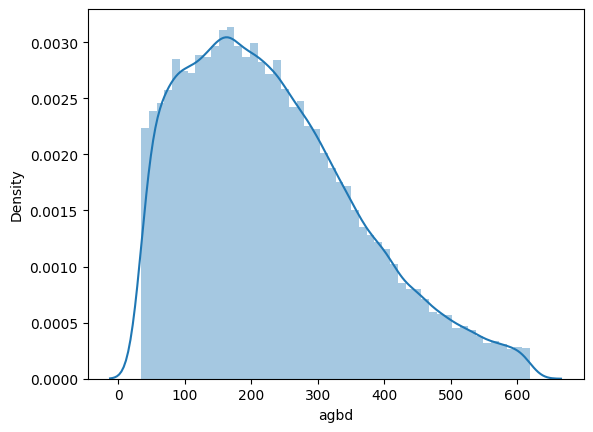

In [ ]:
# Check the  distribution of labeled data
sns.distplot(filtered_data_df['agbd'])
plt.show()

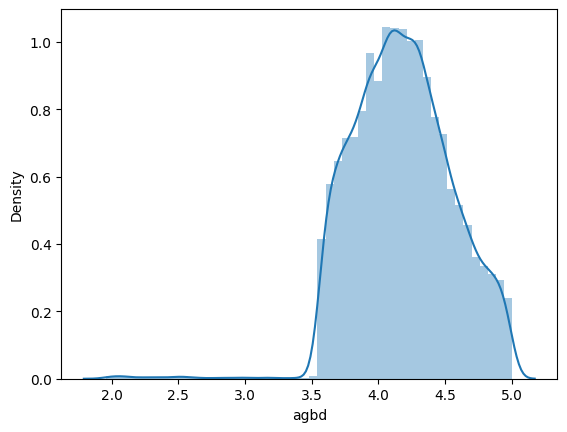

In [ ]:
# It is right skewed. So, we need to do log transformation.

filtered_data_df['agbd'] = np.log1p(filtered_data_df['agbd'])
sns.distplot(filtered_data_df['agbd'])
plt.show()

In [ ]:
x = filtered_data_df.drop('agbd', axis=1)
y = filtered_data_df['agbd']

In [ ]:
# prompt: split the data into train and test

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=42)


In [ ]:
# prompt: Run Random Forest Model and all validation metrics

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Initialize the Random Forest model
rf_model = RandomForestRegressor(random_state=42)

# Fit the model to the training data
rf_model.fit(x_train, y_train)

# Predict on the test data
y_pred = rf_model.predict(x_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the evaluation metrics
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("Mean Absolute Error:", mae)
print("R-squared:", r2)


Mean Squared Error: 13204.849289536209
Root Mean Squared Error: 114.9123548167742
Mean Absolute Error: 89.98953519232478
R-squared: 0.21492319531830395


In [ ]:
# prompt: I got high error and low  r2, please do a hyperparameter tunning and if its possible also do a feature engineering

from sklearn.model_selection import GridSearchCV

# Define the hyperparameter grid to search
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit the grid search to the training data
grid_search.fit(x_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Initialize a new Random Forest model with the best hyperparameters
best_rf_model = RandomForestRegressor(**best_params, random_state=42)

# Fit the best model to the training data
best_rf_model.fit(x_train, y_train)

# Predict on the test data
y_pred_best = best_rf_model.predict(x_test)

# Evaluate the best model
mse_best = mean_squared_error(y_test, y_pred_best)
rmse_best = np.sqrt(mse_best)
mae_best = mean_absolute_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)

# Print the evaluation metrics for the best model
print("Mean Squared Error (Best Model):", mse_best)
print("Root Mean Squared Error (Best Model):", rmse_best)
print("Mean Absolute Error (Best Model):", mae_best)
print("R-squared (Best Model):", r2_best)

# Feature Engineering (example - adding interaction terms)
x_train_engineered = x_train.copy()
x_test_engineered = x_test.copy()
# Fit the best model with engineered features
best_rf_model.fit(x_train_engineered, y_train)

# Predict on the test data with engineered features
y_pred_engineered = best_rf_model.predict(x_test_engineered)

# Evaluate the model with engineered features
mse_engineered = mean_squared_error(y_test, y_pred_engineered)
rmse_engineered = np.sqrt(mse_engineered)
mae_engineered = mean_absolute_error(y_test, y_pred_engineered)
r2_engineered = r2_score(y_test, y_pred_engineered)

# Print the evaluation metrics for the model with engineered features
print("Mean Squared Error (Engineered Features):", mse_engineered)
print("Root Mean Squared Error (Engineered Features):", rmse_engineered)
print("Mean Absolute Error (Engineered Features):", mae_engineered)
print("R-squared (Engineered Features):", r2_engineered)

In [ ]:
# prompt: Visualize the relation between predicted and observed AGB

# Visualize the relation between predicted and observed AGB
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.xlabel("Observed AGB")
plt.ylabel("Predicted AGB")
plt.title("Observed vs. Predicted AGB")
plt.show()


In [ ]:
# # prompt: Run Random Fores Model with Cross Validation and Randomized Search CV

# import numpy as np
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.model_selection import RandomizedSearchCV, cross_val_score

# # Define the parameter grid for randomized search
# param_dist = {
#     'n_estimators': np.arange(50, 501, 50),
#     'max_depth': [None] + list(np.arange(5, 51, 5)),
#     'min_samples_split': np.arange(2, 11),
#     'min_samples_leaf': np.arange(1, 5),
#     'max_features': ['auto', 'sqrt', 'log2']
# }

# # Create a Random Forest Regressor model
# rf_model = RandomForestRegressor(random_state=42)

# # Perform Randomized Search CV with cross-validation
# random_search = RandomizedSearchCV(
#     estimator=rf_model,
#     param_distributions=param_dist,
#     n_iter=100,  # Number of random combinations to try
#     cv=5,  # Number of cross-validation folds
#     scoring='neg_mean_squared_error',  # Use negative MSE for scoring
#     n_jobs=-1,  # Use all available cores
#     verbose=2,
#     random_state=42
# )

# # Fit the randomized search to the training data
# random_search.fit(x_train, y_train)

# # Get the best model from the randomized search
# best_rf_model = random_search.best_estimator_

# # Perform cross-validation on the best model
# cv_scores = cross_val_score(
#     best_rf_model, x_train, y_train, cv=5, scoring='neg_mean_squared_error'
# )

# # Calculate the mean and standard deviation of the cross-validation scores
# mean_cv_rmse = np.sqrt(-cv_scores.mean())
# std_cv_rmse = np.sqrt(cv_scores.std())

# print("Cross-Validation RMSE (Mean):", mean_cv_rmse)
# print("Cross-Validation RMSE (Standard Deviation):", std_cv_rmse)


In [ ]:
# prompt: Do this validation metrices as well: MSE
# RMSE
# R-squaredMAE

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Predict on the test set
y_pred = best_rf_model.predict(x_test)

# Calculate validation metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

# Print the validation metrics
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared:", r2)
print("Mean Absolute Error (MAE):", mae)


In [ ]:
# prompt: visualize it

# Visualize predictions vs actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.xlabel("Actual AGB")
plt.ylabel("Predicted AGB")
plt.title("Actual vs Predicted AGB")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red')  # Add a diagonal line for reference
plt.grid(True)
plt.show()

# Residual plot
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.7)
plt.xlabel("Predicted AGB")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.axhline(y=0, color='red', linestyle='--')  # Add a horizontal line at zero
plt.grid(True)
plt.show()

# Feature importance
feature_importances = best_rf_model.feature_importances_
feature_names = x_train.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title("Feature Importance")
plt.show()


In [ ]:
# prompt: Visualize Validation, show the r2 as well. make a dedicated chart

# ... (preceding code)

# Evaluate the model on the test set
y_pred = best_rf_model.predict(x_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Calculate R-squared
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred)

# Create a scatter plot with a regression line
plt.figure(figsize=(8, 6))
sns.regplot(x=y_test, y=y_pred, scatter_kws={'alpha':0.6})
plt.xlabel('Observed AGB')
plt.ylabel('Predicted AGB')
plt.title('Validation Results (R-squared: {:.6f})'.format(r2))

# Display the plot
plt.show()


In [ ]:
# !pip install --upgrade dtreeviz
# Upgrade dtreeviz to the latest version

import dtreeviz
from dtreeviz.trees import *

viz = dtreeviz.model(best_rf_model.estimators_[0],
               x_train,
               y_train,
               target_name='agbd',
               feature_names=x_train.columns
              )


viz.view()
# Use dtreeviz.trees.dtreeviz instead of dtreeviz.model

In [ ]:
y_test.describe()